In [46]:
import pandas as pd
import cv2
#import cv2imshow
import os
from google.colab.patches import cv2_imshow #use this module in colab

Data Preprocessing

In [47]:
df = pd.read_csv("/content/Licplatesdetection_train.csv")#you can use your dataset
df.head()

,img_id,ymin,xmin,ymax,xmax
0,1.jpg,276,94,326,169
1,10.jpg,311,395,344,444
2,100.jpg,406,263,450,434
3,101.jpg,283,363,315,494
4,102.jpg,139,42,280,222


In [48]:
from google.colab import drive
drive.mount('/content/drive') #mount the drive to access huge amount of data without complexity

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extract Bounding Box Coordinates from DataFrame

359 378 545 421
(547, 821, 3)


<ipython-input-57-3b7c1bb706be>:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  x_min, y_min, x_max, y_max = int(img_bbox["xmin"]), int(img_bbox["ymin"]), int(img_bbox["xmax"]), int(img_bbox["ymax"])


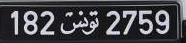

In [57]:
img_bbox = df.loc[df['img_id']=='11.jpg']
x_min, y_min, x_max, y_max = int(img_bbox["xmin"]), int(img_bbox["ymin"]), int(img_bbox["xmax"]), int(img_bbox["ymax"])
print(x_min, y_min, x_max, y_max)
# plot the bbox and visualize
img = cv2.imread("/content/drive/MyDrive/DATA SCIENCE/IMAGES1/11.jpg")#use any image
print(img.shape) # -> (h, w , 3) ->(BGR)

# crop the region
plate = img[y_min:y_max,  x_min:x_max]
cv2_imshow(plate)
# img[]
#cv2.imshow() - it works in jupyter notebook and local computer

Set Up Directories and Parameters

In [58]:
# resize imgs to one size (224,224)
import os
new_size = 224
img_top_path = "licenseplate_detection"
preprocessed_imgs = "output"

# Create the directory if it doesn't exist
os.makedirs(img_top_path, exist_ok=True)
os.makedirs(preprocessed_imgs, exist_ok=True)


Iterate Through Images and Resize

In [59]:

for img_name in os.listdir(img_top_path):
  img_path = os.path.join(img_top_path, img_name)
  img = cv2.imread(img_path)
  print(img.shape) # all the shapes will be different
  h,w,c = img.shape

  #input to my model
  img_resized = cv2.resize(img,(new_size ,new_size))
  cv2.imwrite(f"{preprocessed_imgs}/{img_name}", img_resized )

  # calculate resize ratio
  Rx, Ry = new_size/w, new_size/h

  img_bbox = df.loc[df['img_id']==img_name]
  x_min, y_min, x_max, y_max = int(img_bbox["xmin"]), int(img_bbox["ymin"]), int(img_bbox["xmax"]), int(img_bbox["ymax"])

  # new bbox position- it has to be in int
  x_min, y_min, x_max, y_max = int(Rx*x_min)/new_size, int(Ry*y_min)/new_size, int(Rx*x_max)/new_size, int(Ry*y_max)/new_size

  txt_name = img_name.replace(".jpg",".txt") #1.jpg, 1.txt
  with open(f"{preprocessed_imgs}/{txt_name}", "a") as F:
    F.write(f"{x_min, y_min, x_max, y_max}\n")
  # 100 -> 50

In [7]:
!pip uninstall torchvision -y #update the module
!pip install torchvision

Found existing installation: torchvision 0.18.0
Uninstalling torchvision-0.18.0:
  Successfully uninstalled torchvision-0.18.0
  Using cached torchvision-0.18.0-cp310-cp310-manylinux1_x86_64.whl (7.0 MB)


Create model

In [8]:
# Uninstall and reinstall torch and torchvision
!pip uninstall torch torchvision -y
!pip install torch torchvision

# Import necessary libraries
import torch
import torchvision  # Import torchvision after reinstalling

# Check the versions of torch and torchvision
print(torch.__version__)
print(torchvision.__version__)

# Load the model from torch.hub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

print(model.classifier)
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=4)
print(model.classifier)


Found existing installation: torch 2.3.0
Uninstalling torch-2.3.0:
  Successfully uninstalled torch-2.3.0
Found existing installation: torchvision 0.18.0
Uninstalling torchvision-0.18.0:
  Successfully uninstalled torchvision-0.18.0
  Using cached torch-2.3.0-cp310-cp310-manylinux1_x86_64.whl (779.1 MB)
  Using cached torchvision-0.18.0-cp310-cp310-manylinux1_x86_64.whl (7.0 MB)
2.3.0+cu121
0.18.0+cu121


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 78.0MB/s]


Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)


In [9]:
# write your dataloader

In [10]:
# train your model

Character segmentation

In [66]:
# Read the image and convert to grayscale
image = cv2.imread("/content/drive/MyDrive/DATA SCIENCE/recog/110.jpg",1)
print(image.shape)
plate = image[y_min:y_max,  x_min:x_max]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

ret,thresh = cv2.threshold(gray,150,255,cv2.THRESH_BINARY)

# blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# thresh = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
#  cv2.THRESH_BINARY,11,2)

(35, 188, 3)


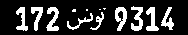

In [67]:
cv2_imshow(thresh)

Find Contours and Generate Bounding Boxes

In [68]:
# find contours
cnts,_ = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
boundingBoxes = [cv2.boundingRect(c) for c in cnts]

Visualize Bounding Boxes on Threshold Image

[(15, 6, 46, 27), (66, 7, 42, 25), (114, 6, 15, 27), (130, 5, 46, 28)]


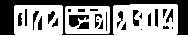

In [85]:
print(boundingBoxes)
for box in boundingBoxes:
  x,y,w,h = box
  cv2.rectangle(thresh,(x,y),(x+w,y+h),(255,0,0),2)
#cv2.imwrite("thresh.jpg",thresh)
cv2_imshow(thresh)

Generate Connected Components Mask



0


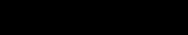

In [70]:
import numpy as np
_, labels = cv2.connectedComponents(thresh)
mask = np.zeros(thresh.shape, dtype="uint8")
# Set lower bound and upper bound criteria for characters
total_pixels = plate.shape[0] * plate.shape[1]
print(total_pixels)
# lower = total_pixels // 100 # heuristic param, can be fine tuned if necessary
# upper = total_pixels //35 # heuristic param, can be fine tuned if necessary
lower = total_pixels // 3 # heuristic param, can be fine tuned if necessary
upper = total_pixels //3 # heuristic param, can be fine tuned if necessary

# Loop over the unique components
for (i, label) in enumerate(np.unique(labels)):
    # If this is the background label, ignore it
    if label == 0:
        continue

    # Otherwise, construct the label mask to display only connected component
    # for the current label
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
    # print(numPixels)

    # If the number of pixels in the component is between lower bound and upper bound,
    # add it to our mask
    if numPixels > lower and numPixels < upper:
      mask = cv2.add(mask, labelMask)
cv2_imshow(mask)

Find Contours and Generate Bounding Boxes

In [71]:
# Find contours and get bounding box for each contour
import functools
import numpy as np
cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boundingBoxes = [cv2.boundingRect(c) for c in cnts]

def compare(rect1, rect2):
    if abs(rect1[1] - rect2[1]) > 10:
        return rect1[1] - rect2[1]
    else:
        return rect1[0] - rect2[0]
boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare) )

Bounding Box Analysis and Selection

[(15, 6, 46, 27), (66, 7, 42, 25), (114, 6, 15, 27), (130, 5, 46, 28)]
15 6 46 27
66 7 42 25
114 6 15 27
130 5 46 28


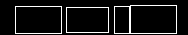

In [72]:
print(boundingBoxes)
heights = []
widths = []
for box in boundingBoxes:
  x,y,w,h = box
  # cv2.rectangle(thresh,(x,y),(x+w,y+h),(255,0,0),1)
  heights.append(h-y)
  widths.append(w-x)

# find mean, std
h_std = np.std(heights)
w_std  =np.std(widths)
h_mean = np.mean(heights)
w_mean  =np.mean(widths)

# specify cut-off to remove outliers
h_cut_off = h_std * 2
lower_h, upper_h = h_mean - h_cut_off, h_mean + h_cut_off

w_cut_off = w_std * 2
lower_w, upper_w = w_mean - w_cut_off, w_mean + w_cut_off
selected_boxes = []
for i,box in enumerate(boundingBoxes):
  x,y,w,h = box
  print(x,y,w,h)
  # print(abs(h_std - (y+h)), abs(w_std - (x+w)))
  # cv2.putText(mask, str(i), (x,y), 0, 0.8, (255, 0, 0), 1)
  if (((h-y) > lower_h) and ((h-y) < upper_h)) and (((w-x) > lower_w) and ((w-x) < upper_w)):
    selected_boxes.append(box)


for box in selected_boxes:
  x,y,w,h = box
  cv2.rectangle(mask,(x,y),(x+w,y+h),(255,0,0),1)

# cv2.imwrite("thresh.jpg",thresh)
cv2_imshow(mask)

Resize Image with Aspect Ratio Preservation

In [73]:
import cv2

def resize_with_aspect_ratio(image, width=None, height=None):
    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the aspect ratio
    aspect_ratio = w / h

    if width is None:
        # Calculate height based on the specified width
        new_height = int(height / aspect_ratio)
        resized_image = cv2.resize(image, (height, new_height))
    else:
        # Calculate width based on the specified height
        new_width = int(width * aspect_ratio)
        resized_image = cv2.resize(image, (new_width, width))

    return resized_image

Preprocess character images

In [74]:

img_top_path = "character_imgs"
preprocessed_imgs = "characters_preprocess"
for img_name in os.listdir(img_top_path):
  img_path = os.path.join(img_top_path, img_name)
  img = cv2.imread(img_path)

  # resize with aspect ratio, since width is longer
  img_resized = resize_with_aspect_ratio(img, height=224)
  print(img_resized.shape)


  img_top_path = "/content/character_imgs"  # Update the path to the correct directory
preprocessed_imgs = "characters_preprocess"
for img_name in os.listdir(img_top_path):
  img_path = os.path.join(img_top_path, img_name)
  img = cv2.imread(img_path)

  # resize with aspect ratio, since width is longer
  img_resized = resize_with_aspect_ratio(img, height=224)
  print(img_resized.shape)



In [ ]:
# Install the numpy library
#!pip install numpy

charcter recognition

In [75]:

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# 0 [1,0,0,0,0,0,0,0,0,0,]
# 1 [0,1,0,0,0,0,0,0,0,0,]



# Import the numpy library
import numpy as np

# Define a function to perform one-hot encoding
def one_hot_encoding(outputs):
  # Assuming outputs is a list of integers
  # Create a one-hot encoded array
  one_hot = np.zeros(len(labels))
  one_hot[outputs] = 1
  return one_hot

output = [0,0,0.02,0.1,0.2,0,0,0,0,0,0,0,0.97,0,0,0,0,0,0,]



categorical cross entropy loss

In [76]:
df = pd.read_csv("/content/Licplatesrecognition_train.csv")

In [77]:
chars = [
    '0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G',
    'H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'
    ]

Convert Text to Character Indices

In [78]:
for index, row in df.iterrows():
  # print(index, row['text'])
  text = row['text']
  output_list = []
  for char in text:
    output_list.append(chars.index(char))

  print(text,output_list)

117T3989 [1, 1, 7, 29, 3, 9, 8, 9]
128T8086 [1, 2, 8, 29, 8, 0, 8, 6]
94T3458 [9, 4, 29, 3, 4, 5, 8]
133T6719 [1, 3, 3, 29, 6, 7, 1, 9]
68T5979 [6, 8, 29, 5, 9, 7, 9]
106T2131 [1, 0, 6, 29, 2, 1, 3, 1]
117T2600 [1, 1, 7, 29, 2, 6, 0, 0]
58T8888 [5, 8, 29, 8, 8, 8, 8]
93T5599 [9, 3, 29, 5, 5, 9, 9]
155T1216 [1, 5, 5, 29, 1, 2, 1, 6]
191T2827 [1, 9, 1, 29, 2, 8, 2, 7]
127T9733 [1, 2, 7, 29, 9, 7, 3, 3]
121T237 [1, 2, 1, 29, 2, 3, 7]
96T8557 [9, 6, 29, 8, 5, 5, 7]
172T9314 [1, 7, 2, 29, 9, 3, 1, 4]
152T8269 [1, 5, 2, 29, 8, 2, 6, 9]
127T9295 [1, 2, 7, 29, 9, 2, 9, 5]
188T956 [1, 8, 8, 29, 9, 5, 6]
179T7121 [1, 7, 9, 29, 7, 1, 2, 1]
169T9685 [1, 6, 9, 29, 9, 6, 8, 5]
161T3230 [1, 6, 1, 29, 3, 2, 3, 0]
74T3819 [7, 4, 29, 3, 8, 1, 9]
155T5259 [1, 5, 5, 29, 5, 2, 5, 9]
137T5115 [1, 3, 7, 29, 5, 1, 1, 5]
156T2325 [1, 5, 6, 29, 2, 3, 2, 5]
169T9685 [1, 6, 9, 29, 9, 6, 8, 5]
134T3970 [1, 3, 4, 29, 3, 9, 7, 0]
120T5039 [1, 2, 0, 29, 5, 0, 3, 9]
121T6559 [1, 2, 1, 29, 6, 5, 5, 9]
145T5368 [1, 4, 5

Segment Characters from License Plate Image

In [79]:
import matplotlib.pyplot as plt

def segment_characters(image) :
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

Identify and Extract License Plate or Character Contours

In [82]:
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)

    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

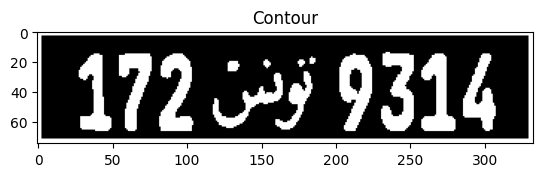

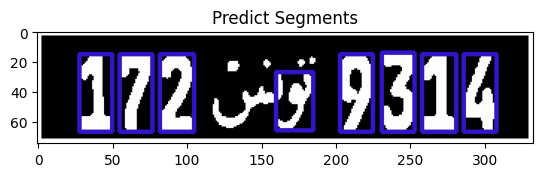

array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0., 255., ..., 255.,   0.,   0.],
        ...,
        [  0.,   0., 255., ..., 253.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0., 217., ..., 242.,   0.,   0.],
        ...,
        [  0.,   0., 255., ..., 255.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0., 255., ..., 255.,   0.,   0.],
        ...,
        [  0.,   0., 236., ..., 236.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       ...,

       [[  0.,   0.,   0

In [83]:
segment_characters(image)